In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Chapter 3 word2vec

이번 장에서는 word2vec의 구조를 차분히 들여다보고 구현해보며 확실하게 이해해보고자 합니다.

이번 장의 목표는 '단순한' word2vec 구현하기입니다.

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점

통계 기반 기법은 대규모 말뭉치를 다룰 때 문제가 생긴다. 영어의 어휘는 100만개를 넘는다고 하는데, 통계 기반 기법에서는 100만 x 100만 행렬을 만들고 SVD를 적용해야 한다. SVD의 시간에 $O(n^3)$만큼 걸린다고 하니, 현실적이지 않다. 

추론 기반 기법은 통계 기반 기법처럼 batch 학습을 진행하는 것이 아니라, mini batch 단위로 학습하기 때문에 학습 효율이 좋다.

<img src="./deep_learning_2_images/fig 3-1.png" width="70%">

### 3.1.2 추론 기반 기법 개요

추론 기반 기법에서 다루는 문제는 아래 그림처럼 단어가 비어있을 때, 어떤 단어가 들어올지를 예측하는 추론 문제이다.

<img src="./deep_learning_2_images/fig 3-2.png" width="60%">

모델 기반 관점에서 보면, 추론 기반 기법에서 학습시키는 모델은 빈 칸에 들어갈 단어의 출현 확률을 구한다. 이 모델이 올바른 추측을 낼 수 있도록 학습시키고, 학습 결과로 단어의 분산 표현을 얻는 것이 추론 기반 기법의 흐름이다.

<img src="./deep_learning_2_images/fig 3-3.png" width="60%">

### 3.1.3 신경망에서의 단어 처리

단어들을 **one-hot encoding**을 이용해 변환해 벡터처럼 만들면, 단어들을 신경망에 넣을 수 있다.

신경망에 넣어서 연산을 한다면 다음과 같은 그림이 된다. 가중치 연산은 matmul을 이용해 수행할 수 있다. 이번 장에서 사용하는 FC(Fully Connected layer)에는 bias가 없다.

<img src="./deep_learning_2_images/fig 3-7.png" width="60%">

다음 그림에서 보면, one-hot encoding으로 바뀐 단어를 가중치 행렬과 matmul하면, 결과는 가중치 행렬의 한 행벡터를 뽑아내는 것하고 똑같다. 이 부분은 다음 장에서 개선할 수 있다.

<img src="./deep_learning_2_images/fig 3-8.png" width="60%">

## 3.2 단순한 word2vec

이번 절에서 사용할 신경망은 word2vec에서 제안하는 **CBOW(continuous bag-of-words)** 모델이다.

### 3.2.1 CBOW 모델의 추론 처리

CBOW 모델은 context로부터 target을 추측한다. CBOW 모델의 입력은 단어들의 목록인 context이다. context 속 단어들을 one-hot encoding으로 만든 다음, 신경망의 입력으로 만든다. 

<img src="./deep_learning_2_images/fig 3-9.png" width="60%">

여기서는 context로 두 개의 단어만들 넣어서 입력 one-hot vector가 두 개이다. context에 N개의 단어가 있다면 입력층도 N개의 one-hot vector가 된다. 

입력층에서 은닉층으로 변화는 모두 동일한 FC를 거친다. (가중치는 $\mathbf{W}_{in}$) 은닉층에서 출력층으로 변환은 다른 FC가 처리한다. (가중치는 $\mathbf{W}_{out}$)

입력층에서 은닉층으로 전환 시 입력층이 여러 개이면, 입력층의 결과를 평균내면 된다. 

출력층의 결과는 각 단어의 "점수"를 의미하고, 이를 softmax 함수에 넣으면 각 단어별 확률이 나온다.

가중치 $\mathbf{W}_{in}$이 바로 단어의 분산 표현이다.

핵심은 은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이다. 위 그림도 입력층의 뉴런 수는 7, 은닉층의 뉴런 수는 3이다. 그래야 단어 예측에 필요한 정보를 간결하게 담게 된다.

아래 코드는 CBOW 모델의 순전파를 다루는 코드이다. 

In [2]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch03/cbow_predict.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

# MatMul layer는 기존 linear layer에서 bias 관련 부분이 빠진 모델이다.
from layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[ 0.09319732  0.27023862  0.8439854  -1.14388835  0.7994283   0.06465257
  -1.07077114]]


### 3.2.2 CBOW 모델의 학습

이전 CBOW 모델에서 나온 점수를 softmax 함수를 거치게 되면 각 단어의 출현 확률을 구할 수 있다. 아래는 softmax 함수까지 적용했을 때 흐름이다.

<img src="./deep_learning_2_images/fig 3-12.png" width="60%">

CBOW 모델은 다중 클래스 분류를 수행하는 신경망이므로, softmax 함수와 cross-entropy loss를 이용하면 된다. 

아래 그림은 CBOW 모델에 softmax 계층과 cross-entropy loss를 동시에 적용했을 때 신경망을 나타낸다. softmax 계층과 cross-entropy 계층을 합쳐서 적용했다. 

<img src="./deep_learning_2_images/fig 3-14.png" width="60%">

### 3.2.3 word2vec의 가중치와 분산 표현

CBOW 모델의 양 가중치 $\mathbf{W}_{in}$과 $\mathbf{W}_{out}$ 모두 단어의 분산 표현이 담겨 있다. 어떤 가중치를 선택해 단어의 분산 표현으로 사용할 지는 세 가지 안이 있다. 
- A : $\mathbf{W}_{in}$만 사용
- B : $\mathbf{W}_{out}$만 사용
- C : 둘을 모두 이용

word2vec은 A안을 이용한다. word2vec과 비슷한 기법인 GloVe는 C안 중 두 가중치를 더했을 때 결과가 좋았다.

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

word2vec의 신경망의 입력은 context이고 정답은 context가 둘러싼 단어인 target이다. 즉, 지금까지 사용한 "You say goodbye and I say hello."에서 context와 target의 쌍을 뽑아내면 다음과 같다. context는 입력이 되고, target은 입력에 대한 정답 label이 된다.

<img src="./deep_learning_2_images/fig 3-16.png" width="60%">

context와 target 쌍을 만들기 위해서는 corpus를 preprocessing 해야 한다. 이를 우리의 corpus에 적용하면 다음 그림이 된다.

<img src="./deep_learning_2_images/fig 3-17.png" width="60%">

context와 target을 만드는 코드를 다음과 같이 구현할 수 있다. (자세한 구현은 util.py에 있다.)

In [3]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/util.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [4]:
from util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

one-hot encoding을 거쳐야 신경망에서 학습을 수행할 수 있다. 다음 그림이 그 과정을 나타낸다.

one-hot encoding 함수는 util.py에 `convert_one_hot()`으로 구현되어 있다.

<img src="./deep_learning_2_images/fig 3-18.png" width="70%">

## 3.4 CBOW 모델 구현

In [5]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch03/simple_cbow.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

import numpy as np
from layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성

        """
        입력층을 처리하는 MatMul 계층
        context 속 단어의 개수만큼 만들어야 한다.
        가중치는 모두 동일한 W_in이다. 
        """
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

다음 그림은 CBOW 모델의 역전파를 나타낸 그림이다. 

<img src="./deep_learning_2_images/fig 3-20.png" width="60%">

### 3.4.1 학습 코드 구현

Trainer class를 이용해 구현했다. 자세한 정보를 원한다면 코드를 찬찬히 읽어보면 될 듯.

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

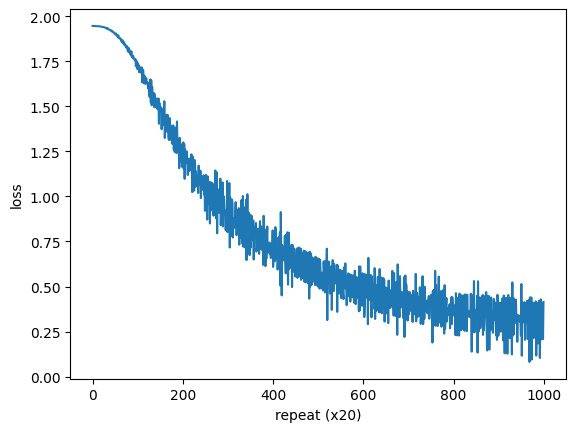

<<< 학습이 끝난 이후 가중치 매개변수 >>>
you [-1.0547185  0.8983078  1.6529762  0.962568  -0.9526104]
say [-0.02855077 -1.271581    0.24811286 -1.2237663   1.2544739 ]
goodbye [-0.9714758   1.0410904  -0.56716406  1.0833424  -1.0445049 ]
and [-1.5821385 -1.0068433  1.4723197 -1.0050616  0.9795014]
i [-0.9766553   1.0422077  -0.56193334  1.0871961  -1.0442506 ]
hello [-1.0541474   0.89348215  1.6480159   0.93078846 -0.9506546 ]
. [ 1.3697284 -1.1828921 -1.4243906 -1.157449   1.1437373]


In [7]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch03/train.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from trainer import Trainer
from optimizer import Adam
from util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 학습이 끝난 이후 가중치 매개변수
print("<<< 학습이 끝난 이후 가중치 매개변수 >>>")
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

학습이 끝난 이후 가중치 매개변수가 우리가 기대하는 단어의 분산 표현이다.

이 CBOW 모델로는 대규모 말뭉치를 다루기 힘들다. 다음 장에서 대규모 말뭉치를 다룰 수 있는 CBOW 모델을 만들어 볼 것이다. 

## 3.5 word2vec 보충

### 3.5.1 CBOW 모델과 확률

CBOW 모델을 확률 표기법으로 기술해보자. CBOW 모델이 하는 일은 context가 들어오면 target 단어가 출현할 확률을 반환하는 것이다. 

corpus를 $w_1, w_2, ..., w_T$처럼 단어들의 sequence로 표현하고 t번째 단어에 대해 윈도우 크기가 1인 맥락을 고려해보자. 그러면 아래 그림과 같은 상황이 만들어진다.

<img src="./deep_learning_2_images/fig 3-22.png" width="60%">

이때, context $w_{t-1}, w_{t+1}$이 주어졌을 때, $w_t$가 등장할 확률을 표현하면 다음과 같다. 

$$P(w_t|w_{t-1}, w_{t+1})$$

위 확률을 이용해 cross-entropy loss를 다시 표현할 수 있다. cross-entropy loss $L=-\Sigma_k{t_k \log{y_k}}$에서 $y_k$는 'k번째에 해당사는 사건이 일어날 확률'이다. $t_k$는 정답 레이블이고, one-hot encoding으로 표현된다. 여기서 $t_k$는 $w_t$가 되므로, CBOW 모델의 loss를 다음 식으로 다시 쓸 수 있다.

$$L=-\log P(w_t|w_{t-1}, w_{t+1})$$

CBOW 모델의 loss function은 log에 음수를 취한 형태로, 이를 **음의 로그 가능도(negative log likelihood)**라고 한다. 위 식은 샘플 데이터 하나에 대한 loss이므로, 이를 전체 corpus로 확장하면 다음과 같다.

$$L=-{{1}\over{T}}\sum_{t=1}^{T} \log P(w_t|w_{t-1}, w_{t+1})$$

여기서는 윈도우 크기가 1인 경우를 나타냈지만, 다른 경우도 충분히 수식으로 나타낼 수 있다.

### 3.5.2 skip-gram 모델

skip-gram 모델은 CBOW 모델이 풀고자 하는 문제의 반대 버전이다. skip-gram 모델은 target이 주어지면 context를 추론하는 모델이다. 

<img src="./deep_learning_2_images/fig 3-23.png" width="70%">

skip-gram 모델의 신경망은 아래 그림처럼 이루어진다.

<img src="./deep_learning_2_images/fig 3-24.png" width="60%">

skip-gram의 출력층은 context의 수만큼 존재한다. 각 출력층별로 softmax와 cross-entropy loss를 적용한 다음, 개별 loss들을 모두 더한 값을 최종 loss로 처리한다.

skip-gram 모델을 확률로 나타내보면 다음과 같이 나타낼 수 있다.

$$P(w_{t-1}, w_{t+1}|w_t)$$

skip-gram 모델에서는 context의 단어들 사이 관련성이 없다고 가정(조건부 독립)하고 다음과 같이 분해한다.

$$P(w_{t-1}, w_{t+1}|w_t)=P(w_{t-1}|w_t)P(w_{t+1}|w_t)$$

위 식을 cross-entropy loss에 적용하면 skip-gram 모델의 loss function을 구할 수 있다.

$$
\begin{aligned}
    L &= -\log P(w_{t-1}, w_{t+1}|w_t) \\
      &= -\log P(w_{t-1}|w_t) P(w_{t+1}|w_t) \\
      &= -\left( \log P(w_{t-1}|w_t) + \log P(w_{t+1}|w_t) \right)
\end{aligned}
$$

이를 말뭉치 전체로 확대하면 다음과 같다. 

$$
L = -\frac{1}{T} \sum_{t=1}^{T} (\log P(w_{t-1}|w_t) + \log P(w_{t+1}|w_t))
$$

CBOW 모델과 skip-gram 모델 중 더 성능이 좋은 모델은 skip-gram 모델이다. 

아래 코드는 skip-gram 모델을 구현한 코드이다. 

In [ ]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch03/simple_skip_gram.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

import numpy as np
from layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

### 3.5.3 통계 기반 vs. 추론 기반

corpus에 새로운 어휘를 추가할 때, 통계 기반 기법은 계산을 처음부터 다시 다 해야 한다. 추론 기반 기법은 매개변수를 새로운 단어를 바탕으로 다시 학습할 수 있다.

통계 기반 기법은 단어의 유사성을 알아낼 수 있지만, word2vec의 경우는 단어의 유사성 뿐만 아니라, 단어 사이의 유추 문제 또한 풀 수 있다.

하지만, 정량적으로 평가했을 때, 통계 기반 기법과 추론 기반 기법의 우열을 가릴 수 없다는 것이 알려져 있다. 

또한, skip-gram 모델과 네거티브 샘플링을 이용한 모델은 corpus 전체의 동시발생 행렬에 특수한 행렬 분해를 적용한 것과 같다는 연구 결과가 있다. 즉, 통계 기반 기법과 추론 기반 기법은 특정 조건 하에 서로 관련이 있다고 볼 수 있다.

word2vec 이후 추론 기반 기법과 통계 기반 기법을 합친 GloVe라는 기법도 있다. GloVe의 아이디어는 corpus 전체의 통계 정보를 loss function에 도입해 mini batch 학습을 하는 것이다.

### 3.6 정리

다음 장에서는 word2vec의 중요성(특히 word2vec의 전이 학습의 유용성)을 구체적인 예를 들어 설명한다.

이번 장에서는 word2vec의 CBOW 모델을 알아보고 구현해봤다. CBOW 모델은 2층 구조의 단순한 신경망이다.